In [1]:
# %pip install numpy
# %pip install scikit-learn
# %pip install pillow
# %pip install kagglehub
# %pip install monai
# %pip install matplotlib
# %pip install torch
# %pip install pylatexenc
# %pip install ipywidgets
# %pip install opencv-python
# %pip install piqture
# %pip install qiskit_machine_learning==0.7.2
# %pip install tensorflow

In [2]:
import os
from IPython.display import clear_output
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from monai.transforms import ScaleIntensity
import kagglehub
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.model_selection import train_test_split
from piqture.neural_networks.layers.convolutional_layer import QuantumConvolutionalLayer
from piqture.neural_networks.layers.pooling_layer import QuantumPoolingLayer2
from qiskit.circuit import QuantumCircuit
from qiskit_algorithms.optimizers import COBYLA
from qiskit.quantum_info import SparsePauliOp
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.algorithms import NeuralNetworkClassifier
from qiskit.circuit.library import ZFeatureMap
import torch
from PIL import Image

import warnings
warnings.filterwarnings("ignore")

#### Download dataset  https://www.kaggle.com/datasets/gurjeetkaurmangat/kidney-ultrasound-images-stone-and-no-stone

In [3]:
path = kagglehub.dataset_download("gurjeetkaurmangat/kidney-ultrasound-images-stone-and-no-stone")

# print("Path to dataset files:", path)

#### Define dataset paths
#### !!! Remove .DS_Store from folders

In [4]:
# !rm -rf f'{path}/my dataset final 512x512(implemented)/Normal/.DS_Store'
# !rm -rf f'{path}/my dataset final 512x512(implemented)/stone/.DS_Store'

In [5]:
dataset_path_normal = f'{path}/my dataset final 512x512(implemented)/Normal'
dataset_path_stone = f'{path}/my dataset final 512x512(implemented)/stone'

#### Count files in directory

In [6]:
def count_images(directory):
    return len([f for f in os.listdir(directory) if f.endswith(('.jpg', '.JPG', '.png', '.jpeg'))])

print("Length dataset_path_normal:", count_images(dataset_path_normal))
print("Length dataset_path_stone:", count_images(dataset_path_stone))

Length dataset_path_normal: 4414
Length dataset_path_stone: 5002


#### Check data

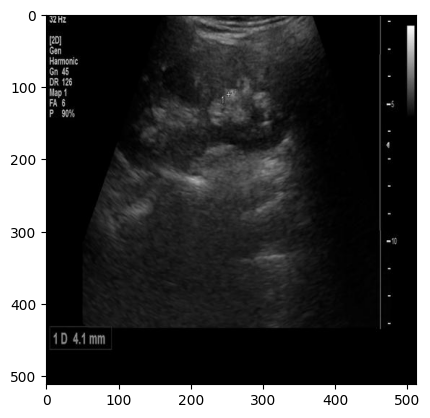

In [7]:
kid_image = cv2.imread(f'{dataset_path_stone}/Stone_7.JPG', cv2.IMREAD_GRAYSCALE)
plt.imshow(kid_image, cmap='gray')

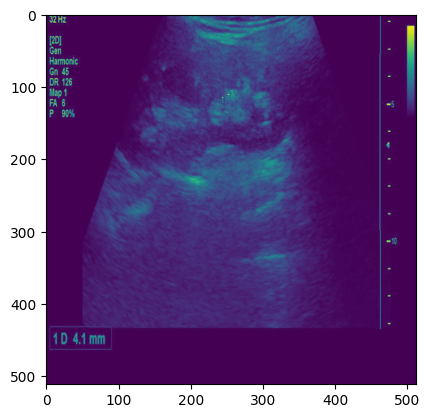

In [8]:
transform_img = ScaleIntensity(minv=0.0, maxv=1.0)
kid_image_scaled = transform_img(kid_image)
colored_kid = cm.viridis(kid_image_scaled)
plt.imshow(colored_kid)

#### Load and preprocess images

In [9]:
img_size = (256, 256)

def load_images_from_folder(folder, label, target_size=img_size):
    """
    Loads images from a given folder and resizes them to the specified target size.
    Converts images to RGB and stores them as numpy arrays (3D).

    Args:
        folder (str): Path to the folder containing images.
        label (int): Label associated with the images in the folder.
        target_size (tuple): Target size to which images will be resized (width, height).

    Returns:
        tuple: A list of image data and their corresponding labels.
    """
    data, labels = [], []
    for img_name in os.listdir(folder):
        img_path = os.path.join(folder, img_name)
        try:
            img = Image.open(img_path).convert("RGB").resize(target_size)
            data.append(np.array(img))
            labels.append(label)
        except Exception as e:
            print(f"Error loading image {img_name}: {e}")
    return np.array(data), np.array(labels)


def load_and_limit_data(path, label, num_samples, target_size=img_size):
    """
    Loads and limits the number of images from a folder to a specified number of samples.
    Ensures images are resized to the specified target size.

    Args:
        path (str): Path to the folder containing images.
        label (int): Label associated with the images in the folder.
        num_samples (int): Maximum number of samples to load.
        target_size (tuple): Target size to which images will be resized (width, height).

    Returns:
        tuple: A numpy array of limited image data and their corresponding labels.
    """
    data, labels = load_images_from_folder(path, label, target_size)
    indices = np.random.choice(len(data), min(num_samples, len(data)), replace=False)
    data = data[indices]
    labels = labels[indices]
    return data, labels

#### Display images for train

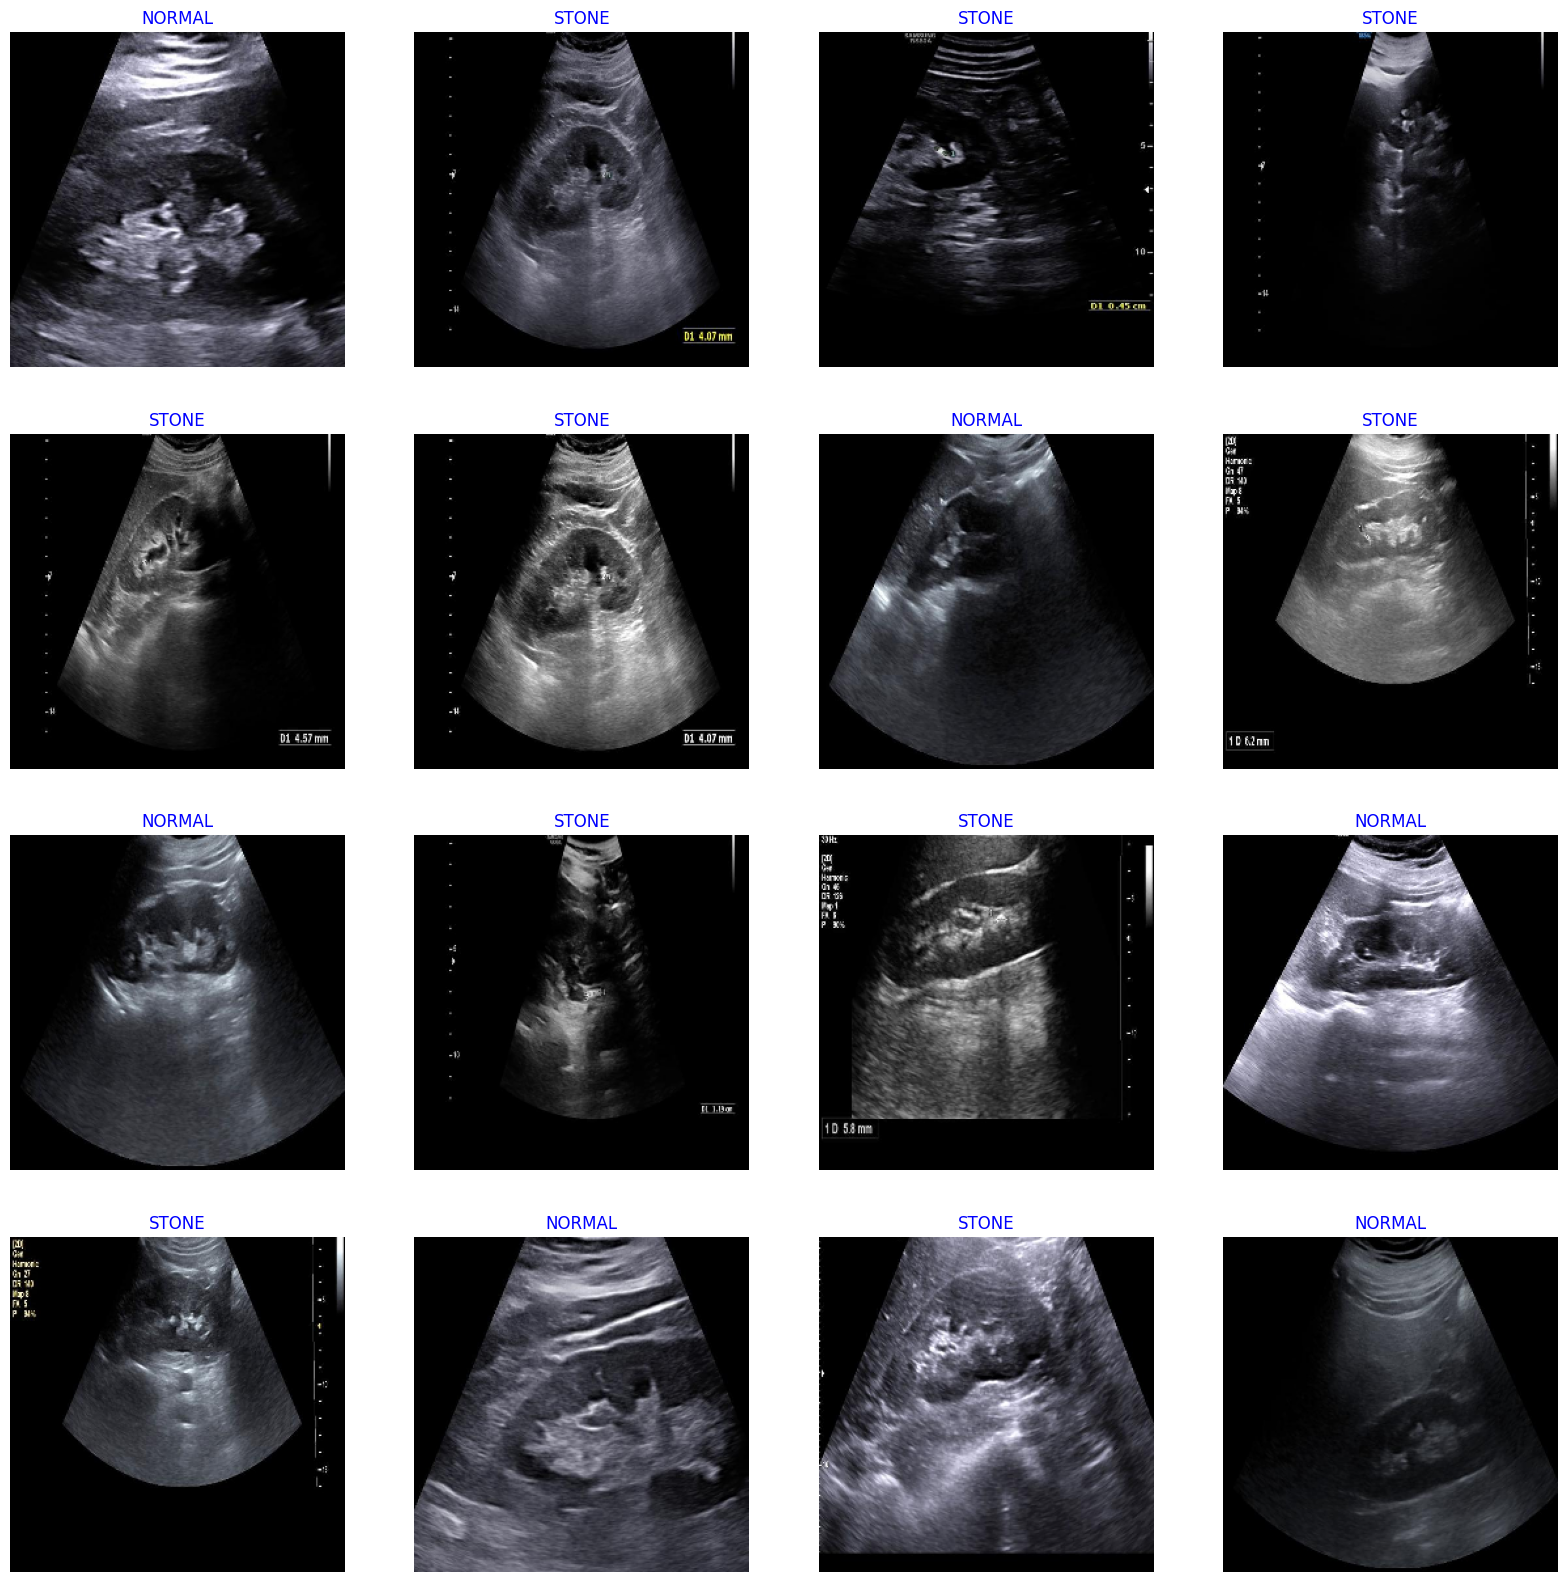

In [10]:
def load_file_paths_and_labels(directory, label):
    filepaths = [os.path.join(directory, fname) for fname in os.listdir(directory) if os.path.isfile(os.path.join(directory, fname))]
    labels = [label] * len(filepaths)
    return filepaths, labels

normal_filepaths, normal_labels = load_file_paths_and_labels(dataset_path_normal, 'NORMAL')
stone_filepaths, stone_labels = load_file_paths_and_labels(dataset_path_stone, 'STONE')

all_filepaths = stone_filepaths + normal_filepaths
all_labels = stone_labels + normal_labels

combined = list(zip(all_filepaths, all_labels))
np.random.shuffle(combined)
all_filepaths, all_labels = zip(*combined)

label_to_index = {'NORMAL': 0, 'STONE': 1}
categorical_labels = np.array([label_to_index[label] for label in all_labels])

def scalar(img):
    return img

def custom_generator(filepaths, labels, batch_size, img_size, preprocessing_function=None):
    while True:
        for i in range(0, len(filepaths), batch_size):
            batch_filepaths = filepaths[i:i + batch_size]
            batch_labels = labels[i:i + batch_size]
            
            images = []
            for filepath in batch_filepaths:
                img = load_img(filepath, target_size=img_size)
                img_array = img_to_array(img)
                if preprocessing_function:
                    img_array = preprocessing_function(img_array)
                images.append(img_array)
            
            yield np.array(images), np.array(batch_labels)

img_size = img_size
batch_size = 32

train_gen = custom_generator(all_filepaths, categorical_labels, batch_size, img_size, preprocessing_function=scalar)

images, labels = next(train_gen)

classes = list(label_to_index.keys())

plt.figure(figsize=(20, 20))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255
    plt.imshow(image)
    class_index = labels[i]
    class_name = classes[class_index]
    plt.title(class_name, color='blue', fontsize=12)
    plt.axis('off')

plt.show()

#### Get training and testing data

In [11]:
normal_data, normal_labels = load_and_limit_data(dataset_path_normal, label=0, num_samples=1000)
stone_data, stone_labels = load_and_limit_data(dataset_path_stone, label=1, num_samples=1400)

all_data = np.concatenate([normal_data, stone_data], axis=0)
all_labels = np.concatenate([normal_labels, stone_labels], axis=0)
X_train, X_test, y_train, y_test = train_test_split(all_data, all_labels, test_size=0.2, random_state=42)

In [12]:
X_train_res = X_train.reshape(X_train.shape[0], -1)
X_test_res = X_test.reshape(X_test.shape[0], -1)

In [13]:
pca = PCA(n_components=8)
X_train_pca = pca.fit_transform(X_train_res)

X_train_tensor = torch.tensor(X_train_pca, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

X_train_tensor = X_train_tensor.to('cpu')
y_train_tensor = y_train_tensor.to('cpu')

In [14]:
X_test_pca = pca.transform(X_test_res)
X_test_tensor = torch.tensor(X_test_pca, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

#### Create & Visualize the QNN

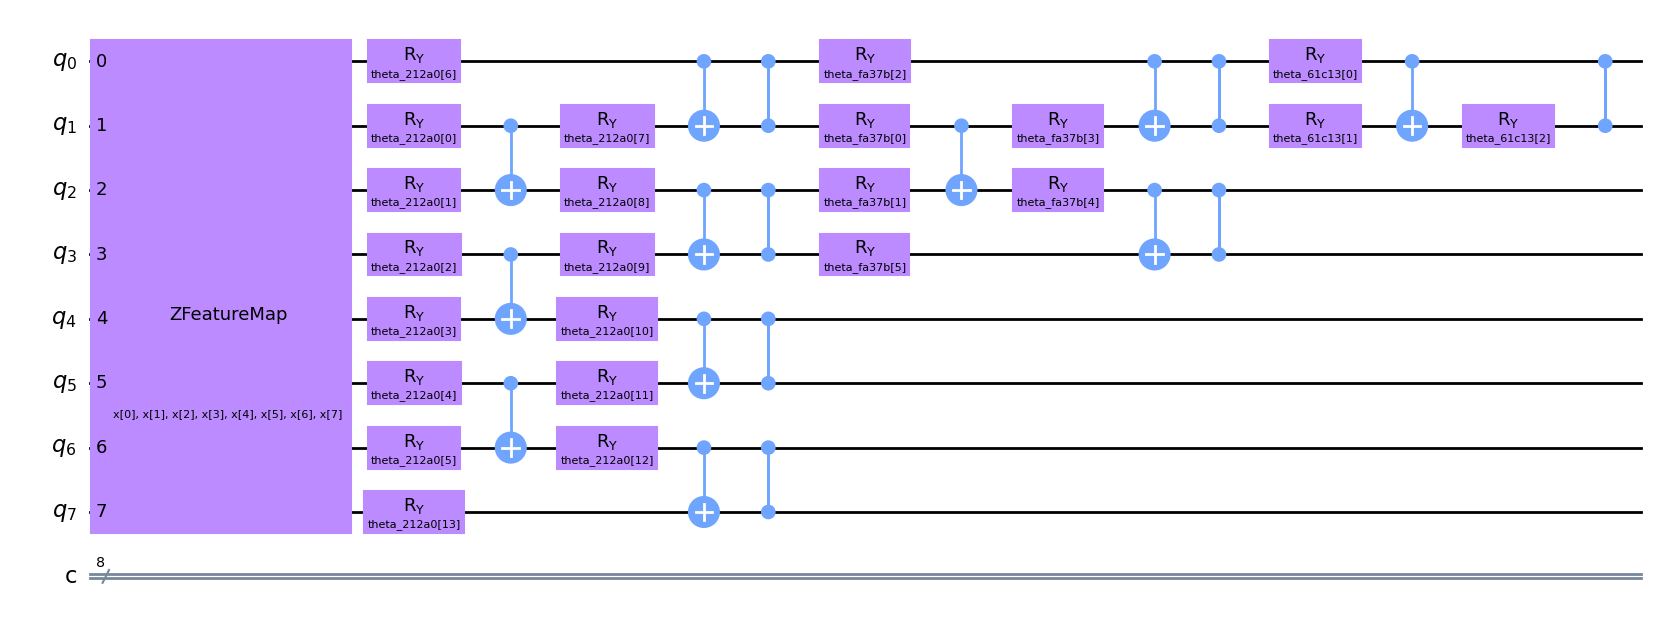

In [15]:
feature_map = ZFeatureMap(8)

ansatz = QuantumCircuit(8, name="Ansatz")

conv_layer1, _ = QuantumConvolutionalLayer(num_qubits=8).build_layer()
ansatz.compose(conv_layer1, list(range(8)), inplace=True)

pool_layer1, _ = QuantumPoolingLayer2(num_qubits=8, circuit=QuantumCircuit(8), unmeasured_bits=list(range(8))).build_layer()
ansatz.compose(pool_layer1, list(range(8)), inplace=True)

conv_layer2, _ = QuantumConvolutionalLayer(num_qubits=4).build_layer()
ansatz.compose(conv_layer2, list(range(4)), inplace=True)

pool_layer2, _ = QuantumPoolingLayer2(num_qubits=4, circuit=QuantumCircuit(4), unmeasured_bits=list(range(4))).build_layer()
ansatz.compose(pool_layer2, list(range(4)), inplace=True)

conv_layer3, _ = QuantumConvolutionalLayer(num_qubits=2).build_layer()
ansatz.compose(conv_layer3, list(range(2)), inplace=True)

pool_layer3, _ = QuantumPoolingLayer2(num_qubits=2, circuit=QuantumCircuit(2), unmeasured_bits=list(range(2))).build_layer()
ansatz.compose(pool_layer3, list(range(2)), inplace=True)

circuit = QuantumCircuit(8)
circuit.compose(feature_map, range(8), inplace=True)
circuit.compose(ansatz, range(8), inplace=True)

observable = SparsePauliOp.from_list([("Z" + "I" * 7, 1)])

qnn = EstimatorQNN(
    circuit=circuit.decompose(),
    observables=observable,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
)

circuit.draw("mpl", style="clifford")

#### Objective function visualization

In [16]:
objective_func_vals = []

def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

#### Train with COBYLA optimizer

In [17]:
NeuralNetworkClassifier.num_classes = 2

In [18]:
classifier = NeuralNetworkClassifier(
    neural_network=qnn,
    optimizer=COBYLA(maxiter=500),
    loss='cross_entropy',
    callback=callback_graph,
)

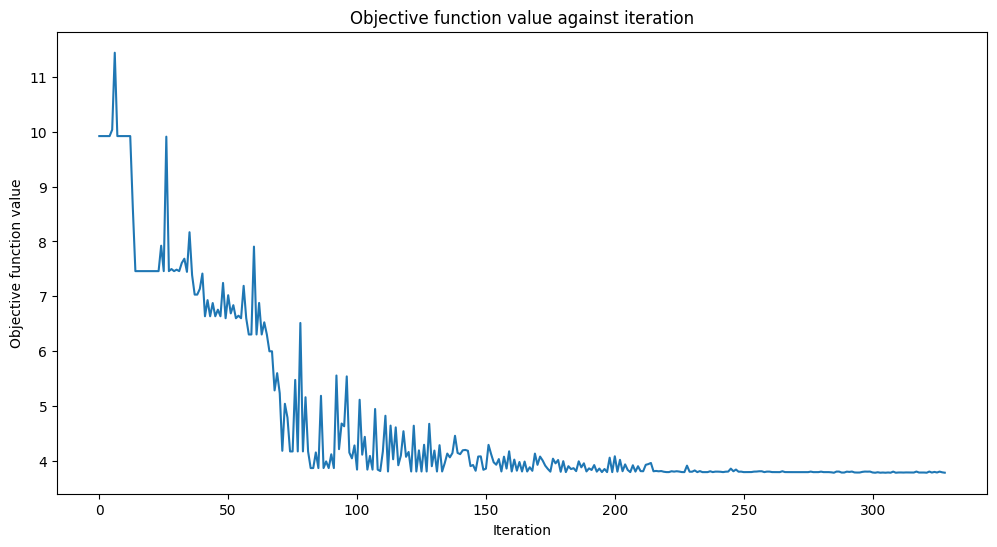

In [19]:
objective_func_vals = []

plt.rcParams["figure.figsize"] = (12, 6)
classifier.fit(X_train_tensor, y_train_tensor)

#### Save model

In [21]:
classifier.save('models/NeuralNetworkClassifier_piqture_stone.model')

#### The evaluation of model

In [22]:
y_pred = classifier.predict(X_test_tensor)

In [23]:
y_pred_binary = (y_pred > 0.5).astype(int)

if y_pred.shape[1] == 2:
    y_pred_binary = np.argmax(y_pred, axis=1)

classification_rep = metrics.classification_report(y_test, y_pred_binary, output_dict=True, zero_division=True)
conf_matrix = metrics.confusion_matrix(y_test, y_pred_binary)
roc_auc = metrics.roc_auc_score(y_test, y_pred_binary)

print("Classification Report:", classification_rep)
print("Confusion Matrix:\n", conf_matrix)
print(f"ROC AUC Score: {roc_auc}")


Classification Report: {'0': {'precision': 0.4727272727272727, 'recall': 0.12206572769953052, 'f1-score': 0.19402985074626866, 'support': 213.0}, '1': {'precision': 0.56, 'recall': 0.8913857677902621, 'f1-score': 0.6878612716763006, 'support': 267.0}, 'accuracy': 0.55, 'macro avg': {'precision': 0.5163636363636364, 'recall': 0.5067257477448963, 'f1-score': 0.44094556121128464, 'support': 480.0}, 'weighted avg': {'precision': 0.5212727272727273, 'recall': 0.55, 'f1-score': 0.4687235786385989, 'support': 480.0}}
Confusion Matrix:
 [[ 26 187]
 [ 29 238]]
ROC AUC Score: 0.5067257477448963


In [24]:
train_accuracy = np.round(100 * classifier.score(X_train_tensor.numpy(), y_train_tensor.numpy()), 2)
print(f"Accuracy from the training data: {train_accuracy}%")
print("***************************************************")
test_accuracy = np.round(100 * classifier.score(X_test_tensor.numpy(), y_test_tensor.numpy()), 2)
print(f"Accuracy from the test data: {test_accuracy}%")
predictions = classifier.predict(X_test_tensor.numpy())
print("***************************************************")
accuracy = np.mean(predictions == y_test_tensor.numpy())
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy from the training data: 52.97%
***************************************************
Accuracy from the test data: 49.58%
***************************************************
Accuracy: 49.25%


#### Predicted probability for Positive Class

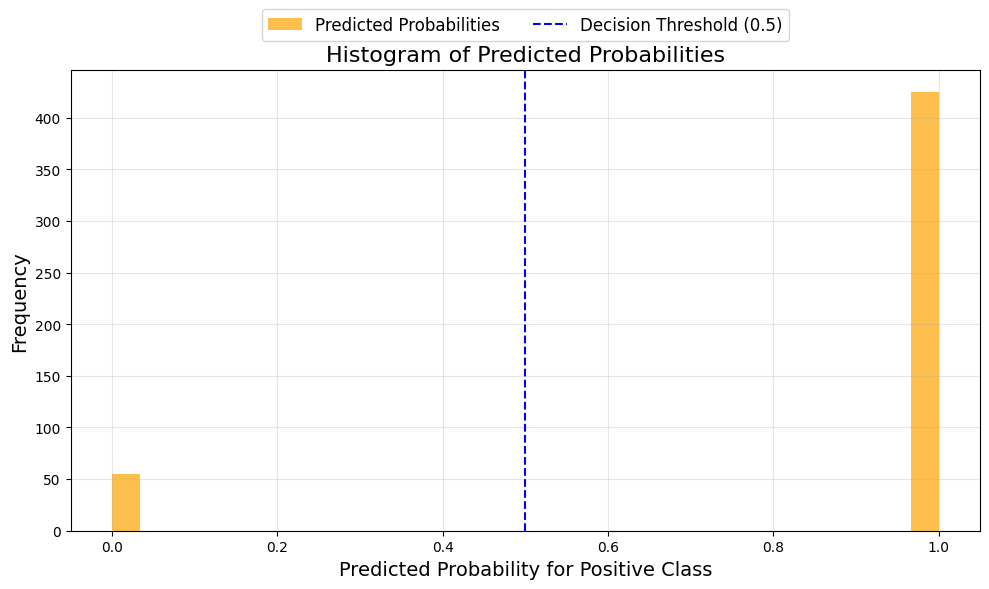

In [25]:
y_pred_probabilities_tensor = torch.tensor(y_pred_binary, dtype=torch.float32)

y_pred_positive_probs = y_pred_probabilities_tensor

predictions = torch.round(y_pred_positive_probs)

plt.figure(figsize=(10, 6))

plt.hist(
    y_pred_positive_probs.numpy(),
    bins=30,
    alpha=0.7,
    color='orange',
    label='Predicted Probabilities'
)

plt.axvline(0.5, color='blue', linestyle='--', label='Decision Threshold (0.5)', linewidth=1.5)

plt.title('Histogram of Predicted Probabilities', fontsize=16)
plt.xlabel('Predicted Probability for Positive Class', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=4, fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

#### PCA of model prediction

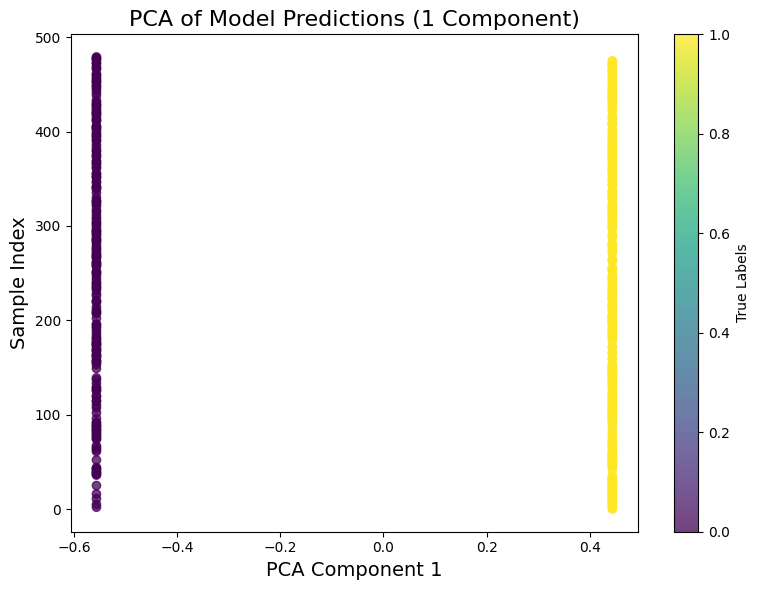

In [26]:
if y_pred.ndim == 1:
    labels_test_reshaped = y_pred_binary.reshape(-1, 1)

pca = PCA(n_components=1)
features_pca = pca.fit_transform(y_test.reshape(-1, 1))

plt.figure(figsize=(8, 6))

plt.scatter(features_pca, range(len(features_pca)), c=y_test, cmap='viridis', alpha=0.75)

plt.colorbar(label='True Labels')
plt.title('PCA of Model Predictions (1 Component)', fontsize=16)
plt.xlabel('PCA Component 1', fontsize=14)
plt.ylabel('Sample Index', fontsize=14)

plt.tight_layout()
plt.show()

#### Plot the confusion matrix

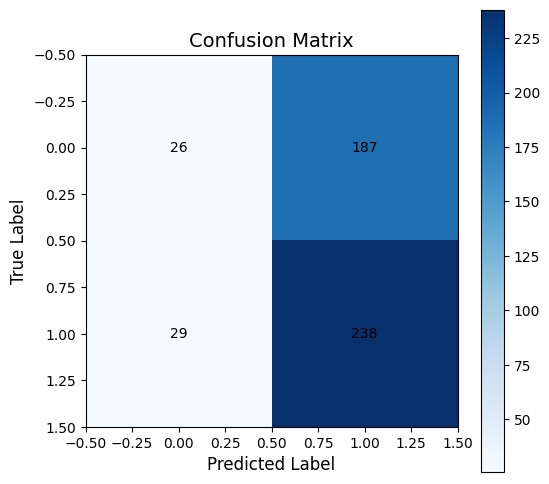

In [27]:
plt.figure(figsize=(6, 6))
plt.title("Confusion Matrix", fontsize=14)
plt.imshow(conf_matrix, interpolation="nearest", cmap=plt.cm.Blues, aspect='equal')
plt.colorbar()

plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)

for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, f"{conf_matrix[i, j]}", ha="center", va="center", color="black", fontsize=10)

plt.show()

#### Load model

In [28]:
loaded_model = classifier.load('models/NeuralNetworkClassifier_piqture_stone.model')

In [29]:
train_score = loaded_model.score(X_train_tensor[:10], y_train[:10])
test_score = loaded_model.score(X_test_tensor[:10], y_test[:10])

print(f"Quantum QSVC on the training dataset: {train_score:.2f}")
print(f"Quantum QSVC on the test dataset: {test_score:.2f}")

Quantum QSVC on the training dataset: 0.50
Quantum QSVC on the test dataset: 0.70


In [30]:
import utils.tutorial_magics

%qiskit_version_table
%qiskit_copyright